In [1]:
!which python
!pwd

/Users/administrator/opt/miniconda3/envs/kaggle/bin/python
/Users/administrator/zuev/prog/made/2_cv/kaggle


In [2]:
%load_ext autoreload
%autoreload 2

# %load_ext pycodestyle_magic
# %flake8_on --max_line_length 119
# %pycodestyle_on

In [3]:
import os
import pdb
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
from torchvision.transforms import transforms
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

from utils import utils
import matplotlib.pyplot as plt

In [4]:
torch.set_num_threads(8)

In [5]:
!tree data --filelimit=100

data
├── vk-made-sports-image-classification
│   ├── test  [19446 entries exceeds filelimit, not opening dir]
│   ├── test.csv
│   ├── train  [45373 entries exceeds filelimit, not opening dir]
│   └── train.csv
└── vk-made-sports-image-classification.zip

3 directories, 3 files


In [7]:
PATH_TO_TRAIN_DATA = "/Users/administrator/zuev/prog/made/2_cv/kaggle/data/vk-made-sports-image-classification"
TORCH_RANDOM = torch.Generator().manual_seed(42)
BATCH_SIZE = 64
EPOCHS = 25

In [8]:
!echo "train:" & head -n 3 $PATH_TO_TRAIN_DATA/train.csv
!echo "\ntest:" & head -n 3 $PATH_TO_TRAIN_DATA/test.csv

train:
image_id,label
46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg,swimming
ec66e513-adac-4a30-b6a9-3d647ee6e46b.jpeg,greco-Roman_wrestling

test:
image_id
00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg
ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg


In [9]:
def get_file_extensions_in_dir(directory):
    return set(map(lambda x: x.split(".")[-1], os.listdir(directory)))

In [10]:
train_file_extenstions = get_file_extensions_in_dir(f"{PATH_TO_TRAIN_DATA}/train")

assert train_file_extenstions == {"jpeg"}

In [11]:
test_file_extenstions = get_file_extensions_in_dir(f"{PATH_TO_TRAIN_DATA}/test")

assert test_file_extenstions == {"jpeg"}

In [12]:
# LabelEncoder().fit_transform(pd.read_csv(f"{PATH_TO_TRAIN_DATA}/train.csv")["label"].values)

In [13]:
le = LabelEncoder().fit(pd.read_csv(f"{PATH_TO_TRAIN_DATA}/train.csv")["label"].values)


def encode_one_element(x, le=le):
    return le.transform([x])[0]

def decode_one_element(x, le=le):
    return le.inverse_transform([x])[0]

In [14]:
CLASS_COUNT = len(le.classes_)
CLASS_COUNT

30

In [14]:
full_dataset = utils.ImageDataset(
    f"{PATH_TO_TRAIN_DATA}/train.csv",
    f"{PATH_TO_TRAIN_DATA}/train/",
    transform=None,
    target_transform=encode_one_element,
)

In [15]:
full_dataset[0]

(tensor([[[ 62,  60,  59,  ...,  74,  75,  76],
          [ 60,  60,  58,  ...,  74,  75,  75],
          [ 60,  59,  58,  ...,  73,  74,  74],
          ...,
          [ 67,  66,  65,  ...,  89,  86,  85],
          [ 66,  65,  64,  ...,  89,  86,  85],
          [ 65,  65,  64,  ...,  89,  87,  85]],
 
         [[121, 122, 121,  ..., 131, 132, 133],
          [122, 122, 121,  ..., 131, 132, 132],
          [123, 122, 123,  ..., 130, 131, 131],
          ...,
          [158, 157, 156,  ..., 161, 159, 158],
          [157, 156, 155,  ..., 161, 159, 158],
          [156, 156, 155,  ..., 161, 158, 158]],
 
         [[163, 163, 162,  ..., 160, 161, 162],
          [163, 163, 162,  ..., 160, 161, 161],
          [166, 165, 165,  ..., 159, 160, 160],
          ...,
          [203, 202, 201,  ..., 201, 200, 199],
          [202, 201, 200,  ..., 201, 200, 201],
          [201, 201, 200,  ..., 201, 200, 201]]], dtype=torch.uint8),
 24)

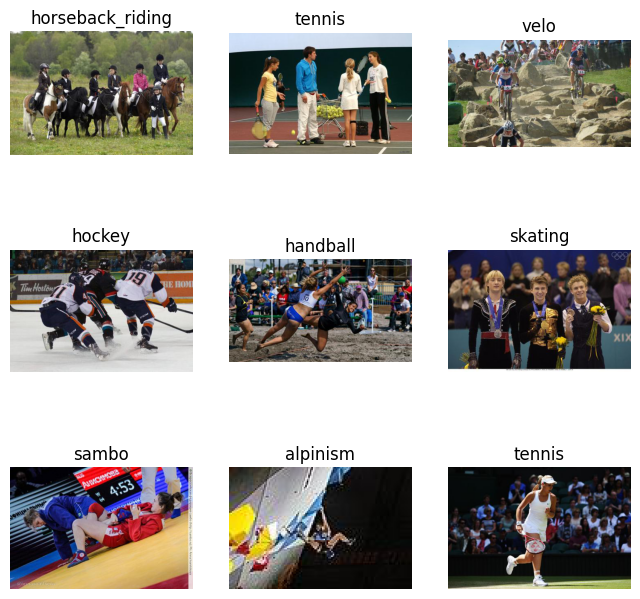

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(full_dataset), size=(1,)).item()
    img, label = full_dataset[sample_idx]
    img = torch.permute(img, (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(decode_one_element(label))
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

In [ ]:
img.shape

In [18]:
img.squeeze().shape

torch.Size([299, 448, 3])

# Test pretrained models

In [15]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset

In [19]:
dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

No config specified, defaulting to: cats-image/image
Found cached dataset cats-image (/Users/administrator/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)


  0%|          | 0/1 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tiger cat


In [20]:
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits
    
logits

tensor([[-11.1069,  -9.7877,  -8.3777, -11.7053, -10.8944, -10.8401, -12.2616,
         -10.1248, -11.2489, -12.1733, -10.5038, -12.8779, -11.8846, -12.3679,
         -10.4132, -11.3135,  -9.3991, -11.2852, -11.0961, -12.9520,  -9.4024,
         -12.1240, -10.7898, -11.7456, -10.6141, -10.5283, -12.2900, -10.3484,
          -9.4641, -11.0942, -10.5226, -10.0925,  -9.2266, -10.6685, -10.1492,
          -9.5051,  -8.8385,  -9.1157, -13.1274, -12.3425,  -9.0918, -11.7719,
         -10.2494, -11.7164,  -9.1436, -11.6954, -11.0127, -11.4385, -12.0745,
         -10.6454, -10.1812, -10.9976, -10.9342, -11.5494, -10.3468, -13.2261,
         -10.9294, -10.3238, -10.2486, -10.6505,  -5.9666,  -9.7594, -11.8681,
          -9.5500, -11.6809, -10.0314, -10.4925, -10.3785, -10.5080,  -9.2594,
         -10.8284,  -9.2076, -11.5033, -11.0808, -11.2402,  -9.4876, -12.1381,
         -10.3297,  -8.6665,  -9.0119, -11.6243, -12.8412, -10.8360, -12.3102,
         -12.4031, -12.1111,  -9.5663, -13.3644, -10

In [174]:
model(**inputs)

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[-0.0153,  0.0584, -0.0125, -0.1035,  0.0106,  0.0390, -0.0718, -0.0035,
         -0.0208, -0.0372, -0.0019,  0.0591, -0.1973,  0.1415,  0.1313,  0.2018,
          0.0076, -0.1709, -0.0225,  0.1468,  0.1587, -0.1373,  0.0603, -0.1111,
         -0.0293,  0.0299,  0.1961,  0.0741,  0.0159, -0.0629]],
       grad_fn=<AddmmBackward0>), hidden_states=None)

In [169]:
inputs

{'pixel_values': tensor([[[[ 0.2967,  0.4679,  0.4508,  ..., -0.6794, -0.4911, -0.4568],
          [ 0.3309,  0.4337,  0.3309,  ..., -0.6452, -0.6281, -0.5938],
          [ 0.3309,  0.3823,  0.3309,  ..., -0.9363, -0.8849, -0.8335],
          ...,
          [ 1.9749,  2.0434,  1.9235,  ...,  1.9920,  2.0948,  2.0263],
          [ 1.8893,  2.0263,  2.0434,  ...,  2.0263,  2.0092,  2.0434],
          [ 1.9407,  2.0434,  1.9407,  ...,  2.0777,  2.0263,  1.9920]],

         [[-1.5455, -1.4930, -1.5455,  ..., -1.8081, -1.7906, -1.7381],
          [-1.5280, -1.4755, -1.5980,  ..., -1.8081, -1.8081, -1.7906],
          [-1.5630, -1.5280, -1.4755,  ..., -1.8957, -1.8782, -1.8606],
          ...,
          [-0.5476, -0.4776, -0.5826,  ..., -0.4601, -0.4076, -0.4951],
          [-0.6702, -0.5826, -0.6176,  ..., -0.4601, -0.5126, -0.5301],
          [-0.6527, -0.4601, -0.6352,  ..., -0.5126, -0.4076, -0.5301]],

         [[-0.6367, -0.4973, -0.5321,  ..., -1.3339, -1.2467, -1.1770],
          [-0

In [23]:
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [ ]:
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


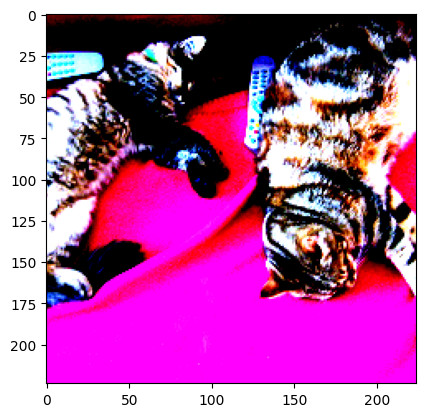

In [25]:
plt.imshow(processor(image, return_tensors="pt")["pixel_values"].squeeze().permute(1, 2, 0))

In [26]:
processor(image, return_tensors="pt")["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [27]:
image = read_image("./data/vk-made-sports-image-classification/train/0001edd2-e2a0-4d38-a386-8f365a9586e8.jpeg")

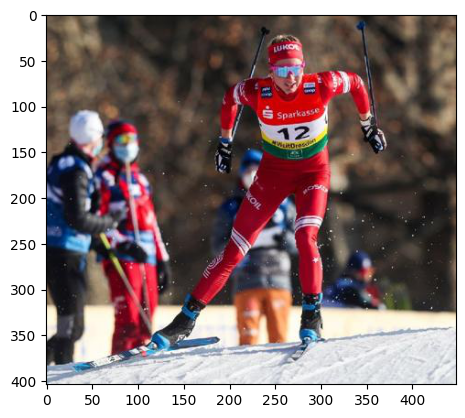

In [28]:
plt.imshow(image.squeeze().permute(1, 2, 0))

In [29]:
image.shape

torch.Size([3, 404, 448])

In [30]:
img = processor(image, return_tensors="pt")["pixel_values"]

In [31]:
img.shape

torch.Size([1, 3, 224, 224])

In [32]:
img.squeeze().shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


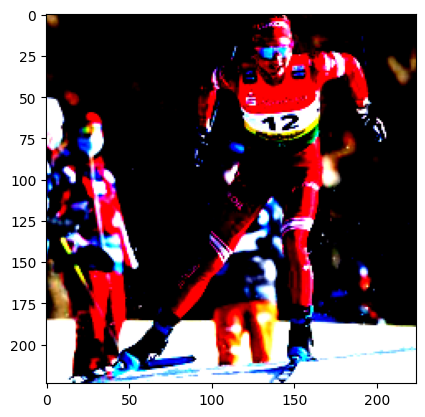

In [33]:
plt.imshow(img.squeeze().permute(1, 2, 0))

In [34]:
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

ski


In [35]:
model.config.id2label

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [36]:
AutoImageProcessor

transformers.models.auto.image_processing_auto.AutoImageProcessor

In [37]:
model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [38]:
model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=1000, bias=True)
)

In [39]:
full_dataset = utils.ImageDataset(
    f"{PATH_TO_TRAIN_DATA}/train.csv",
    f"{PATH_TO_TRAIN_DATA}/train/",
    transform=lambda x: processor(x, return_tensors="pt"),
    target_transform=encode_one_element,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


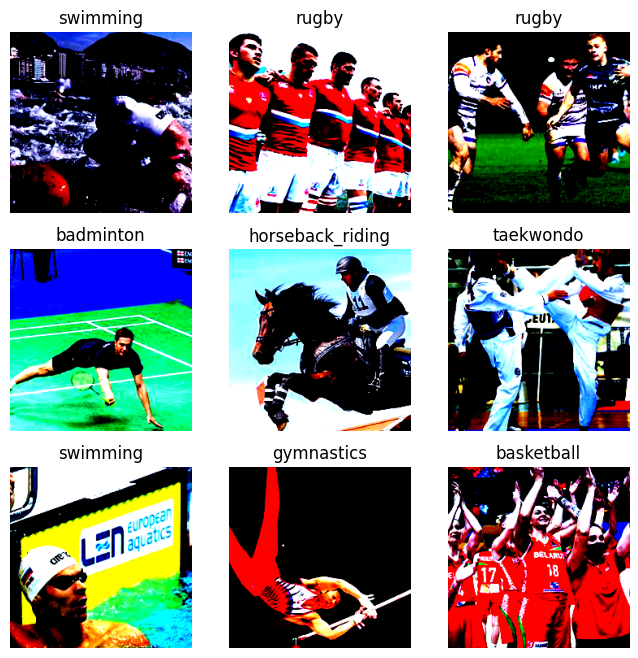

In [40]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(full_dataset), size=(1,)).item()
    img, label = full_dataset[sample_idx]
#     img = torch.permute(img["pixel_values"], (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(decode_one_element(label))
    plt.axis("off")
    plt.imshow(img["pixel_values"].squeeze().permute(1, 2, 0))

plt.show()

## PL Train loop

In [16]:
# transform = transforms.Compose([
#     transforms.Lambda(lambda x: processor(x, return_tensors="pt")["pixel_values"].squeeze()),
#     transforms.ToTensor()
# ])

# def preproc(x, processor=processor):
#     return processor(x, return_tensors="pt")["pixel_values"].squeeze()

full_dataset = utils.ImageDataset(
    f"{PATH_TO_TRAIN_DATA}/train.csv",
    f"{PATH_TO_TRAIN_DATA}/train/",
#     transform=lambda x: processor(x, return_tensors="pt")["pixel_values"].squeeze(),
    transform=None, # перенес код явно в даталоудер, так как не понял как распараллелить нормально
#     target_transform=encode_one_element, 
    target_transform=None, # перенес код явно в даталоудер, так как не понял как распараллелить нормально
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.85, 0.1, 0.05], TORCH_RANDOM)
# train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], TORCH_RANDOM)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [18]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

model.classifier[1] = torch.nn.Linear(2048, CLASS_COUNT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [19]:
# for name, param in model.resnet.named_parameters():
#     param.requires_grad = False

# model.resnet.eval()

In [20]:
class PLModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
#         print(x)
#         print(x.keys())
#         print(x["pixel_values"].shape)
        return self.model(x).logits
            
    def step(self, batch, batch_idx, step, prog_bar=False):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        
        y_preds = preds.argmax(1).cpu().numpy()
        y_true = y.cpu().numpy()
        score = f1_score(y_true, y_preds, average="micro").astype(np.float32)
        
        self.log(f"{step}_loss", loss, prog_bar=prog_bar)
        self.log(f"{step}_f1", score, prog_bar=prog_bar)
        
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        
        y_preds = preds.argmax(1).cpu().numpy()
        y_true = y.cpu().numpy()
        score = f1_score(y_true, y_preds, average="micro").astype(np.float32)

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log(f"test_f1", score, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val", True)
        
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
#         lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
#         scheduler = {
#             'scheduler': lr_scheduler,
#             'reduce_on_plateau': True,
#             'monitor': 'val_loss'
#         }
#         return [optimizer], [scheduler]
    
    def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=1e-3
        )
        

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1,
            patience=3, eps=1e-4, verbose=True
        )
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
pl_model = PLModule(model)

trainer = pl.Trainer(
    accelerator="mps", 
    log_every_n_steps=5, 
    max_epochs=EPOCHS, 
    val_check_interval=0.1,
    limit_val_batches=0.25
)
trainer.fit(
    model=pl_model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                         | Params
-----------------------------------------------------------
0 | model     | ResNetForImageClassification | 23.6 M
1 | criterion | CrossEntropyLoss             | 0     
-----------------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.278    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/administrator/opt/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test(pl_model, dataloaders=test_dataloader)

In [ ]:
torch.save(pl_model.model.state_dict(), "./models/model_v3")

## Make submit

In [25]:
pd.read_csv(f"{PATH_TO_TRAIN_DATA}/test.csv")

,image_id
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg
...,...
19441,01ec2a50-db12-4b98-94da-1dd9372650cf.jpeg
19442,1596a0c0-5772-4309-8781-47e15dcdd5d5.jpeg
19443,65610b2c-c137-468a-85a6-a3ec2ed9e87f.jpeg
19444,5630e635-fce1-4a33-8748-b7416d16fffc.jpeg


In [32]:
from PIL import Image

class TMPDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
        self.le = LabelEncoder().fit(pd.read_csv(f"/Users/administrator/zuev/prog/made/2_cv/kaggle/data/vk-made-sports-image-classification/train.csv")["label"].values)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = transforms.ToTensor()(Image.open(img_path).convert("RGB"))
        image = self.processor(image, return_tensors="pt")["pixel_values"].squeeze()

        return image, self.img_labels.iloc[idx, 0]

In [44]:
submit_dataset = TMPDataset(
    f"{PATH_TO_TRAIN_DATA}/test.csv",
    f"{PATH_TO_TRAIN_DATA}/test/"
)

submit_dataloader = DataLoader(submit_dataset, batch_size=BATCH_SIZE * 10, shuffle=False, num_workers=0)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
pl_model.model.to("mps")
pl_model.eval()
result = [[], []]

with torch.no_grad():
    for x, y in tqdm(submit_dataloader):
        preds = pl_model(x.to("mps"))
        preds = preds.argmax(1)
        
        result[0].extend(le.inverse_transform(preds.cpu()))
        result[1].extend(y)

# print(f"cer: {model.cer(result[0], result[1])}")
# model.model.train();

In [57]:
pl_model.model.to("mps")
pl_model.eval()
result = [[], []]

with torch.no_grad():
    for x, y in tqdm(test_dataloader):
        preds = pl_model(x.to("mps"))
        preds = preds.argmax(1)
        
        result[0].extend(le.inverse_transform(preds.cpu()))
        result[1].extend(le.inverse_transform(y))
        break

# print(f"cer: {model.cer(result[0], result[1])}")
# model.model.train();

  0%|          | 0/284 [00:00<?, ?it/s]

In [58]:
pd.DataFrame(result).T

,0,1
0,skating,skating
1,tennis,tennis
2,taekwondo,taekwondo
3,running,archery
4,basketball,basketball
5,volleyball,volleyball
6,sambo,sambo
7,boating,boating
8,running,running
9,running,running


In [60]:
t1 = pd.read_csv("submit.csv")
t2 = pd.read_csv(f"{PATH_TO_TRAIN_DATA}/test.csv")

In [64]:
t = pd.concat([t2, t1], axis=1)
t.columns = ["image_id", "label"]

In [65]:
t

,image_id,label
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg,ski_race
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg,basketball
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg,alpinism
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg,tennis
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg,fencing
...,...,...
19441,01ec2a50-db12-4b98-94da-1dd9372650cf.jpeg,skating
19442,1596a0c0-5772-4309-8781-47e15dcdd5d5.jpeg,boxing
19443,65610b2c-c137-468a-85a6-a3ec2ed9e87f.jpeg,basketball
19444,5630e635-fce1-4a33-8748-b7416d16fffc.jpeg,water_polo


In [66]:
t.to_csv("submit.csv", index=False)

In [50]:
pd.read_csv(f"{PATH_TO_TRAIN_DATA}/test.csv")

,image_id
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg
...,...
19441,01ec2a50-db12-4b98-94da-1dd9372650cf.jpeg
19442,1596a0c0-5772-4309-8781-47e15dcdd5d5.jpeg
19443,65610b2c-c137-468a-85a6-a3ec2ed9e87f.jpeg
19444,5630e635-fce1-4a33-8748-b7416d16fffc.jpeg


In [252]:
pl_model.eval()
result = [[], []]

with torch.no_grad():
    for x, y in tqdm(test_dataloader):
        preds = pl_model(x)
        preds = preds.argmax(1)
        
        result[0].extend(le.inverse_transform(y))
        result[1].extend(le.inverse_transform(preds))

# print(f"cer: {model.cer(result[0], result[1])}")
# model.model.train();

  0%|          | 0/284 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [254]:
f1_score(result[0], result[1], average="micro")

0.8604910714285714

array(['sailing', 'rugby', 'running', 'volleyball', 'horseback_riding',
       'rugby', 'archery', 'boxing', 'velo', 'sailing', 'water_polo',
       'ski_race', 'archery', 'ski_race', 'football', 'fencing',
       'basketball', 'sambo', 'boating', 'volleyball', 'taekwondo',
       'tennis', 'gymnastics', 'gymnastics', 'alpinism', 'running',
       'fencing', 'water_polo', 'sailing', 'football', 'tennis',
       'taekwondo'], dtype=object)

In [236]:
# torch.save(pl_model.model.state_dict(), "./models/model_v1")

In [245]:
decode_one_element(17)

'rugby'

In [217]:
full_dataset = utils.ImageDataset(
    f"{PATH_TO_TRAIN_DATA}/train.csv",
    f"{PATH_TO_TRAIN_DATA}/train/",
    transform=lambda x: processor(x, return_tensors="pt")["pixel_values"].squeeze(),
    target_transform=encode_one_element,
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [103]:
# for i in range(len(full_dataset)):
#     print(i)
#     full_dataset[i][0].shape

In [111]:
# for i in range(2):
#     pdb.set_trace()
#     full_dataset[3681]

In [112]:
# plt.imshow(full_dataset[3681][0].squeeze().permute(1, 2, 0))

tensor([[[ 0.4337,  0.5878,  0.7419,  ..., -1.7240, -1.7412, -1.7412],
         [ 0.3138,  0.4508,  0.5707,  ..., -1.7069, -1.7240, -1.7240],
         [ 0.1597,  0.2796,  0.4166,  ..., -1.6898, -1.6727, -1.6898],
         ...,
         [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
         [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
         [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152]],

        [[ 1.6408,  1.7633,  1.9034,  ..., -1.1779, -1.2129, -1.2479],
         [ 1.5182,  1.6408,  1.7808,  ..., -1.1429, -1.1779, -1.1954],
         [ 1.3957,  1.5182,  1.6408,  ..., -1.0903, -1.1078, -1.1429],
         ...,
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957]],

        [[ 2.6400,  2.6226,  2.6051,  ..., -0.5495, -0.6018, -0.6715],
         [ 2.6051,  2.6226,  2.6051,  ..., -0

In [72]:
len(full_dataset)

45373

In [61]:
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.7, 0.1, 0.2], TORCH_RANDOM)
# train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], TORCH_RANDOM)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [62]:
for x in valid_dataloader:
    print(x[0].shape)

RuntimeError: stack expects each tensor to be equal size, but got [3, 342, 448] at entry 0 and [3, 281, 448] at entry 1